# Practice with TensorFlow, Keras, and PyTorch


## Setup & Utilities

In [1]:
import os, math, time, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error

np.random.seed(42)  # reproducibility
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True

## Problem 1–2

In [4]:
#!pip install tensorflow
import tensorflow as tf
print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.8439 - loss: 0.5321 - val_accuracy: 0.9798 - val_loss: 0.0635
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.9793 - loss: 0.0666 - val_accuracy: 0.9843 - val_loss: 0.0524
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.9873 - loss: 0.0411 - val_accuracy: 0.9882 - val_loss: 0.0367
Tutorial-style CNN — Test accuracy: 0.9874


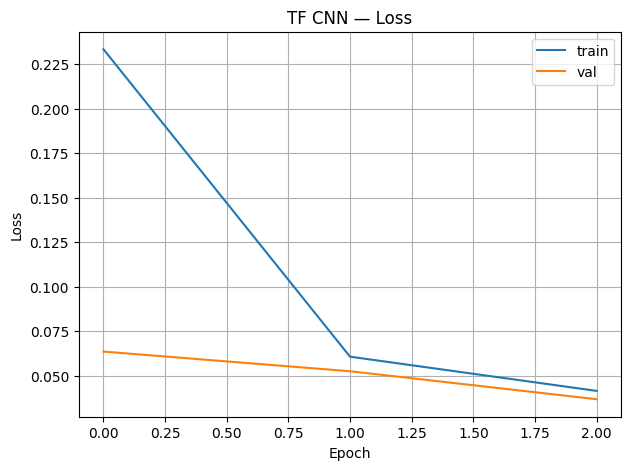

In [5]:
# Load MNIST (downloads if needed)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # (N, 28,28,1)
x_test  = np.expand_dims(x_test, -1)

# Simple CNN
model_tf_tutorial = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])
model_tf_tutorial.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist_tut = model_tf_tutorial.fit(x_train, y_train, validation_split=0.1, epochs=3, batch_size=128, verbose=1)
test_loss, test_acc = model_tf_tutorial.evaluate(x_test, y_test, verbose=0)
print("Tutorial-style CNN — Test accuracy:", round(test_acc, 4))

# Plot learning curve
plt.figure()
plt.plot(hist_tut.history['loss'], label='train')
plt.plot(hist_tut.history['val_loss'], label='val')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("TF CNN — Loss")
plt.legend(); plt.show()

## Shared helpers for Keras/PyTorch sections

In [6]:
def ensure_house_prices_csv(path="/content/train.csv"):
    if not os.path.exists(path):
        print(f"[WARN] House Prices train.csv not found at {path}. Please place it there before running that section.")
    return path

def plot_learning_curves(history, title="Learning Curve"):
    plt.figure()
    plt.plot(history.history.get('loss', []), label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel("Epoch"); plt.title(title); plt.legend(); plt.show()


## Problem 3: Iris (binary classification) with Keras

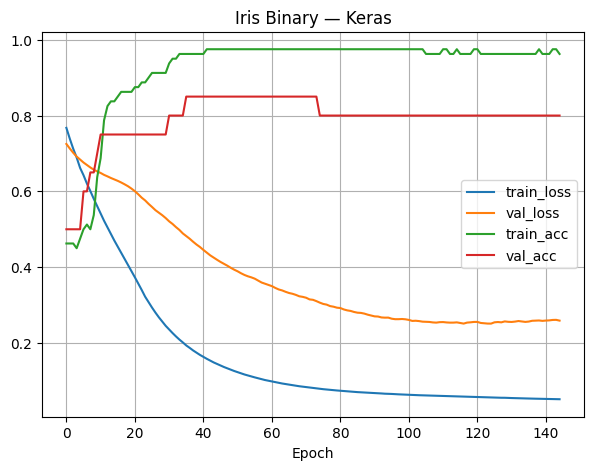

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Accuracy: 0.8
Precision: 0.875
Recall: 0.7
Confusion matrix:
 [[9 1]
 [3 7]]
              precision    recall  f1-score   support

           0      0.750     0.900     0.818        10
           1      0.875     0.700     0.778        10

    accuracy                          0.800        20
   macro avg      0.812     0.800     0.798        20
weighted avg      0.812     0.800     0.798        20



In [7]:
from sklearn.datasets import load_iris
import tensorflow as tf

iris = load_iris()
X_all = iris.data
y_all = iris.target  # 0=setosa,1=versicolor,2=virginica

# Keep only versicolor (1) and virginica (2), map to {0,1}
mask = y_all != 0
X = X_all[mask]
y = (y_all[mask] == 2).astype(np.int64)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

model_bin = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_bin.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cb = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")]
hist_bin = model_bin.fit(X_train_s, y_train, validation_data=(X_val_s, y_val), epochs=400, batch_size=16, verbose=0, callbacks=cb)
plot_learning_curves(hist_bin, "Iris Binary — Keras")

# Evaluation
y_pred_prob = model_bin.predict(X_val_s).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=3))

## Problem 4: Iris (multiclass, 3 classes) with Keras

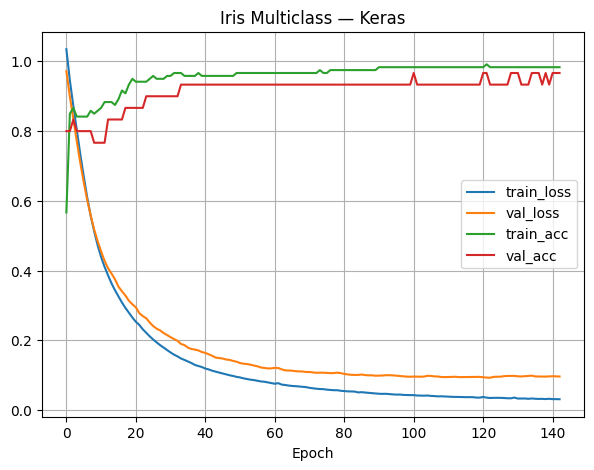

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Accuracy: 0.9333333333333333
Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      0.900     0.900     0.900        10
           2      0.900     0.900     0.900        10

    accuracy                          0.933        30
   macro avg      0.933     0.933     0.933        30
weighted avg      0.933     0.933     0.933        30



In [8]:
iris = load_iris()
X = iris.data
y = iris.target  # 0,1,2

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

num_classes = 3
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes)

model_mc = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])
model_mc.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cb = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")]
hist_mc = model_mc.fit(X_train_s, y_train_oh, validation_data=(X_val_s, y_val_oh), epochs=400, batch_size=16, verbose=0, callbacks=cb)
plot_learning_curves(hist_mc, "Iris Multiclass — Keras")

y_pred_prob = model_mc.predict(X_val_s)
y_pred = np.argmax(y_pred_prob, axis=1)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=3))

## Problem 5: House Prices (regression) with Keras

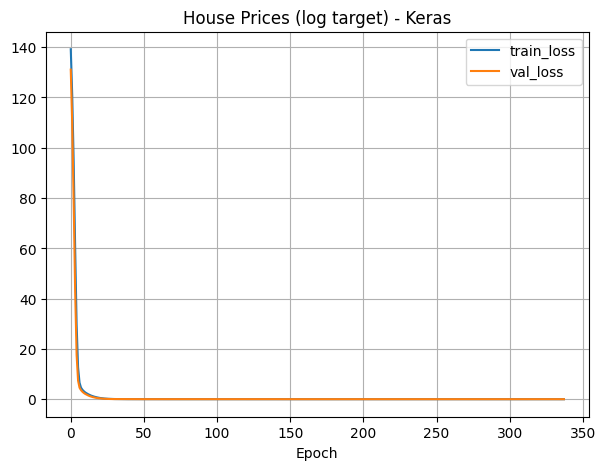

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RMSE (log space): 0.2172
RMSE (price): 47106.29


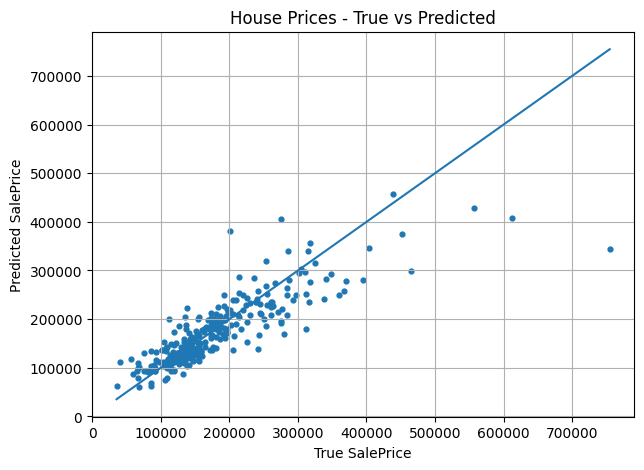

In [9]:
csv_path = ensure_house_prices_csv("/content/train.csv")
df = pd.read_csv(csv_path)

# Keep core features; you can add more
features = ["GrLivArea", "YearBuilt"]
target = "SalePrice"

df = df.dropna(subset=features + [target]).copy()
X = df[features].values.astype("float32")
y = df[target].values.astype("float32")

# Log-transform target (often improves MSE for prices)
y_log = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

model_hp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_s.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)  # linear
])
model_hp.compile(optimizer="adam", loss="mse", metrics=["mse"])
cb = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss")]
hist_hp = model_hp.fit(X_train_s, y_train, validation_data=(X_val_s, y_val), epochs=1000, batch_size=32, verbose=0, callbacks=cb)
plot_learning_curves(hist_hp, "House Prices (log target) - Keras")

y_val_pred_log = model_hp.predict(X_val_s).ravel()
rmse = math.sqrt(mean_squared_error(y_val, y_val_pred_log))
print("RMSE (log space):", round(rmse, 4))

# Bring back to price space for interpretability
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)
rmse_price = math.sqrt(mean_squared_error(y_val_true, y_val_pred))
print("RMSE (price):", round(rmse_price, 2))

# Plot predicted vs true
plt.figure()
plt.scatter(y_val_true, y_val_pred, s=12)
plt.xlabel("True SalePrice"); plt.ylabel("Predicted SalePrice")
plt.title("House Prices - True vs Predicted")
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()])
plt.show()

## Problem 6: MNIST (multiclass) with Keras

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8616 - loss: 0.4867 - val_accuracy: 0.9639 - val_loss: 0.1238
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9706 - loss: 0.1021 - val_accuracy: 0.9682 - val_loss: 0.1171
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9820 - loss: 0.0604 - val_accuracy: 0.9758 - val_loss: 0.0793
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9868 - loss: 0.0425 - val_accuracy: 0.9741 - val_loss: 0.0848
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9912 - loss: 0.0296 - val_accuracy: 0.9750 - val_loss: 0.0865
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9927 - loss: 0.0228 - val_accuracy: 0.9720 - val_loss: 0.1046
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9943 - loss: 0.0186 - val_accuracy: 0.9733 - val_loss: 0.0951
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9958 - loss: 0.0135 - val_accu

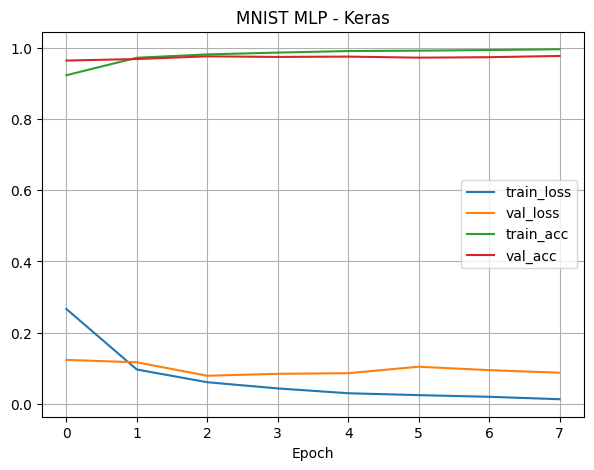

MNIST - Test accuracy: 0.9784


In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32")/255.0
x_test  = x_test.reshape(-1, 784).astype("float32")/255.0

num_classes = 10
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes)

model_mnist = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(784,)),
    tf.keras.layers.Dense(400, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])
model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cb = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")]
hist_mnist = model_mnist.fit(x_train, y_train_oh, validation_split=0.2, epochs=20, batch_size=128, verbose=1, callbacks=cb)

plot_learning_curves(hist_mnist, "MNIST MLP - Keras")
test_loss, test_acc = model_mnist.evaluate(x_test, y_test_oh, verbose=0)
print("MNIST - Test accuracy:", round(test_acc, 4))

## Problem 7: PyTorch rewrites for the four tasks

In [11]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__, " Device:", device)

def train_torch(model, loader, criterion, optimizer, epochs=100, val_loader=None):
    model.to(device)
    hist = {"loss": [], "val_loss": []}
    for ep in range(epochs):
        model.train()
        running = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        hist["loss"].append(running / len(loader.dataset))
        if val_loader is not None:
            model.eval(); vrun = 0.0
            with torch.no_grad():
                for xv, yv in val_loader:
                    xv, yv = xv.to(device), yv.to(device)
                    out = model(xv)
                    vrun += criterion(out, yv).item() * xv.size(0)
            hist["val_loss"].append(vrun / len(val_loader.dataset))
    return hist

# Iris Binary
iris = load_iris()
X_all = iris.data
y_all = iris.target
mask = y_all != 0
X = X_all[mask].astype("float32")
y = (y_all[mask] == 2).astype("int64")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype("float32")
X_val_s = scaler.transform(X_val).astype("float32")

ds_tr = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train))
ds_va = TensorDataset(torch.from_numpy(X_val_s), torch.from_numpy(y_val))
dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=128)

class IrisBinNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, 2)  # logits for 2 classes
        )
    def forward(self, x): return self.net(x)

m_bin = IrisBinNet(X_train_s.shape[1])
crit = nn.CrossEntropyLoss()
opt = optim.Adam(m_bin.parameters(), lr=1e-3)
hist = train_torch(m_bin, dl_tr, crit, opt, epochs=200, val_loader=dl_va)

m_bin.eval()
with torch.no_grad():
    logits = m_bin(torch.from_numpy(X_val_s).to(device)).cpu().numpy()
y_pred = logits.argmax(1)
print("[PyTorch] Iris Binary - Accuracy:", accuracy_score(y_val, y_pred))

# ---- Iris 3-class ----
iris = load_iris()
X = iris.data.astype("float32")
y = iris.target.astype("int64")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype("float32")
X_val_s = scaler.transform(X_val).astype("float32")

ds_tr = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train))
ds_va = TensorDataset(torch.from_numpy(X_val_s), torch.from_numpy(y_val))
dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=128)

class Iris3Net(nn.Module):
    def __init__(self, in_dim, out_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, out_dim)
        )
    def forward(self, x): return self.net(x)

m_mc = Iris3Net(X_train_s.shape[1])
crit = nn.CrossEntropyLoss()
opt = optim.Adam(m_mc.parameters(), lr=1e-3)
_ = train_torch(m_mc, dl_tr, crit, opt, epochs=200, val_loader=dl_va)

with torch.no_grad():
    logits = m_mc(torch.from_numpy(X_val_s).to(device)).cpu().numpy()
y_pred = logits.argmax(1)
print("[PyTorch] Iris 3-class — Accuracy:", accuracy_score(y_val, y_pred))

# House Prices (regression)
csv_path = ensure_house_prices_csv("/content/train.csv")
df = pd.read_csv(csv_path)
features = ["GrLivArea", "YearBuilt"]
df = df.dropna(subset=features + ["SalePrice"]).copy()
X = df[features].values.astype("float32")
y = np.log1p(df["SalePrice"].values.astype("float32"))  # log target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype("float32")
X_val_s = scaler.transform(X_val).astype("float32")

ds_tr = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train.reshape(-1,1)))
ds_va = TensorDataset(torch.from_numpy(X_val_s), torch.from_numpy(y_val.reshape(-1,1)))
dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=128)

class RegrNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x): return self.net(x)

m_reg = RegrNet(X_train_s.shape[1])
crit = nn.MSELoss()
opt = optim.Adam(m_reg.parameters(), lr=1e-3)
_ = train_torch(m_reg, dl_tr, crit, opt, epochs=300, val_loader=dl_va)

with torch.no_grad():
    y_pred_log = m_reg(torch.from_numpy(X_val_s).to(device)).cpu().numpy().ravel()
rmse_log = math.sqrt(mean_squared_error(y_val, y_pred_log))
rmse_price = math.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_log)))
print(f"[PyTorch] House Prices - RMSE log: {rmse_log:.4f}, RMSE price: {rmse_price:.2f}")

PyTorch: 2.8.0+cpu  Device: cpu
[PyTorch] Iris Binary - Accuracy: 0.85
[PyTorch] Iris 3-class — Accuracy: 0.9666666666666667
[PyTorch] House Prices - RMSE log: 0.2231, RMSE price: 49363.13


In [12]:
# MNIST (MLP)
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.view(-1))
])

train_ds = datasets.MNIST(root="datasets", train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root="datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256)


class MnistMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 400), nn.ReLU(),
            nn.Linear(400, 200), nn.ReLU(),
            nn.Linear(200, 10)
        )
    def forward(self, x): return self.net(x)

m_mnist = MnistMLP().to(device)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(m_mnist.parameters(), lr=1e-3)

# quick train (few epochs)
for ep in range(3):
    m_mnist.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = m_mnist(xb)
        loss = crit(out, yb)
        loss.backward()
        opt.step()

m_mnist.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = m_mnist(xb)
        pred = out.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
print("[PyTorch] MNIST - Test accuracy (few epochs):", round(correct/total, 4))

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


[PyTorch] MNIST - Test accuracy (few epochs): 0.9735



## Problem 8: Comparing frameworks (summary)

**Speed (typical, small-to-medium problems):**
- TensorFlow 2.x + `tf.keras` and PyTorch are broadly comparable on GPU; data input pipelines can dominate.
- For CPU-only small tabular datasets (Iris/House Prices), overhead dominates; both are fast enough.

**Code size & readability:**
- `tf.keras` and PyTorch high-level APIs keep models concise (Sequential/Module); training loops:
  - Keras: `model.fit(...)` is extremely terse.
  - PyTorch: explicit training loop is more verbose but very flexible.
- Low-level TF 1.x graphs are most verbose (placeholders, sessions).

**Features:**
- Keras (`tf.keras`): batteries-included training, callbacks (EarlyStopping, ReduceLROnPlateau), built-in metrics.
- PyTorch: very flexible autograd, dynamic graphs; lightning/ignite/ecosystem add high-level conveniences.
- TensorFlow: ecosystem with TF-Serving, TF Lite, XLA, `tf.data`, TPU support.

**When to choose what:**
- Quick prototypes & standard DL: `tf.keras` or higher-level PyTorch (Lightning).
- Custom research layers/losses: PyTorch often fastest to iterate.
- Production with TensorFlow tooling (Serving/Lite/TPUs): favor TF.
